In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Conv2d , Dropout , MaxPool2d
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
def CIFAR10_dataset(batch_size=64,shuffle=True):
    training_data = datasets.CIFAR10(
        root="CIFAR10",
        train=True,
        transform=ToTensor(),
        download=True
    )
    testing_data = datasets.CIFAR10(
        root="CIFAR10",
        train=False,
        transform=ToTensor(),
        download=True
    )
    train_dataloader = DataLoader(training_data,batch_size=batch_size,shuffle=shuffle)
    test_dataloader = DataLoader(testing_data,batch_size=batch_size,shuffle=shuffle)
    return train_dataloader,test_dataloader,training_data,testing_data

In [19]:
def convert_to_cuda(train_dataloader):
    for x , y in train_dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

    return train_dataloader

In [33]:
train_dataloader , test_dataloader , training_data , testing_data = CIFAR10_dataset(batch_size=64)
train_dataloader = convert_to_cuda(train_dataloader)


Files already downloaded and verified
Files already downloaded and verified


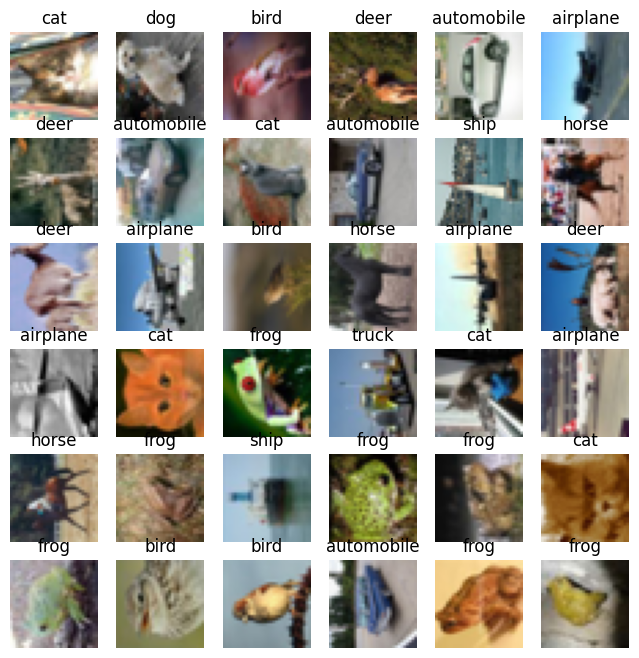

In [34]:
def plot_samples(cols=3,rows=3):
  labels = {
    1:"airplane",
    2:"automobile",
    3:"bird",
    4:"cat",
    5:"deer",
    6:"dog",
    7:"frog",
    8:"horse",
    9:"ship",
    10:"truck"
  }
  figure = plt.figure(figsize=(8, 8))
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(training_data), size=(1,)).item()
      img, label = training_data[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(str(labels[label+1]))
      plt.axis("off")
      plt.imshow(img.T)#, cmap="gray")
  plt.show()
plot_samples(6,6)

In [35]:
def plot_eval(title,train_acc,test_acc,train_loss,test_loss):
    fig = plt.figure(figsize=(13,6))
    # loss
    ax = fig.add_subplot(121)
    ax.set_title(title + " Loss/Epoch")
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_loss, label='Train', color='blue', linewidth=3)
    plt.plot(test_loss, label='Validation', color='red', linewidth=3)
    plt.legend()
    # acc
    ax = fig.add_subplot(122)
    ax.set_title(title + " Accuracy/Epoch")
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_acc, label='Train', color='blue', linewidth=3)
    plt.plot(test_acc, label='Validation', color='red', linewidth=3)
    plt.legend()

In [46]:
class CNNNetworkClassifier(nn.Module):
    def __init__(self):
        super(CNNNetworkClassifier,self).__init__()
        self.flatten = nn.Flatten()
        self.block1 = nn.Sequential(
            Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(64),
            MaxPool2d(kernel_size=2,stride=2)
        )

        self.block2 = nn.Sequential(
            Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(128),
            MaxPool2d(kernel_size=2,stride=2)
        )
        self.block3 = nn.Sequential(
            Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(256),
            MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.decider = nn.Sequential(
            nn.Dropout2d(0.3),
            nn.Linear(256*4*4,256),
            nn.ReLU(),
            # nn.BatchNorm2d(4096),
            nn.Linear(256,64),
            nn.ReLU(),
            # nn.BatchNorm2d(1024),
            nn.Linear(64,10),
        )
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        # self.log_prob_loss = nn.LogSoftmax(dim=-1)
        self.optimizer = torch.optim.Adam(params=self.parameters(),lr=1e-3)
    
    def forward(self,X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        # X = self.block4(X)
        X = self.flatten(X)
        X = self.decider(X)
        return X
    
    def train_epoch(self,dataloader):
        self.train()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss,correct = 0,0
        for batch, (X, y) in enumerate(dataloader):
          # Compute prediction and loss
          X = X.cuda()
          y = y.cuda()
          pred = self.forward(X)
          loss_fn = self.cross_entropy_loss(pred, y)

          # Backpropagation
          self.optimizer.zero_grad()
          loss_fn.backward()
          self.optimizer.step()

        with torch.no_grad():
          for X,y in dataloader:
            X = X.cuda()
            y = y.cuda()
            pred = self.forward(X)
            train_loss += self.loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
        train_loss/=num_batches
        correct/=size
        print(f"Train Accuracy: {(100*correct):>0.1f}%, Avg train loss: {train_loss:>8f}  ")
        return correct , train_loss

    def test_epoch(self,dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
#         loss_fn = self.cross_entropy_loss()
        with torch.no_grad():
            for X, y in dataloader:
                X = X.cuda()
                y = y.cuda()
                pred = self.forward(X)
                test_loss += self.cross_entropy_loss(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")
        return correct , test_loss

    def fit(self,train_dataloader,test_dataloader,epochs):
        train_acc = np.zeros(epochs)
        train_loss = np.zeros(epochs)
        test_acc = np.zeros(epochs)
        test_loss = np.zeros(epochs)
        for epoch in range(epochs):
          print(f"Epoch {epoch+1}  ")
          train_accuracy , train_cost = self.train_epoch(train_dataloader)
          test_accuracy , test_cost = self.test_epoch(test_dataloader)
          train_acc[epoch] = train_accuracy
          train_loss[epoch] = train_cost
          test_acc[epoch] = test_accuracy
          test_loss[epoch] = test_cost
        print("Done!")
        # save the model
        torch.save(self.state_dict(),f="CIFAR10 CNN Model")
        return train_acc,train_loss,test_acc,test_loss

In [47]:
model = CNNNetworkClassifier().to(device=device)
train_acc , train_loss , test_acc , test_loss = model.fit(
    train_dataloader,
    test_dataloader,
    epochs = 30
)

Epoch 1  


c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Accuracy: 56.4%, Avg train loss: 1.198072  
Test Accuracy: 56.6%, Avg test loss: 1.226018 

Epoch 2  
Train Accuracy: 68.5%, Avg train loss: 0.888050  
Test Accuracy: 66.9%, Avg test loss: 0.943945 

Epoch 3  
Train Accuracy: 73.9%, Avg train loss: 0.742440  
Test Accuracy: 71.3%, Avg test loss: 0.822296 

Epoch 4  
Train Accuracy: 77.3%, Avg train loss: 0.654111  
Test Accuracy: 73.9%, Avg test loss: 0.753589 

Epoch 5  
Train Accuracy: 79.3%, Avg train loss: 0.591476  
Test Accuracy: 75.1%, Avg test loss: 0.720964 

Epoch 6  
Train Accuracy: 81.3%, Avg train loss: 0.537912  
Test Accuracy: 76.1%, Avg test loss: 0.697373 

Epoch 7  
Train Accuracy: 83.4%, Avg train loss: 0.469992  
Test Accuracy: 77.2%, Avg test loss: 0.678967 

Epoch 8  
Train Accuracy: 85.0%, Avg train loss: 0.428400  
Test Accuracy: 78.2%, Avg test loss: 0.650127 

Epoch 9  
Train Accuracy: 86.4%, Avg train loss: 0.392283  
Test Accuracy: 78.5%, Avg test loss: 0.647988 

Epoch 10  
Train Accuracy: 87.7%, Avg 

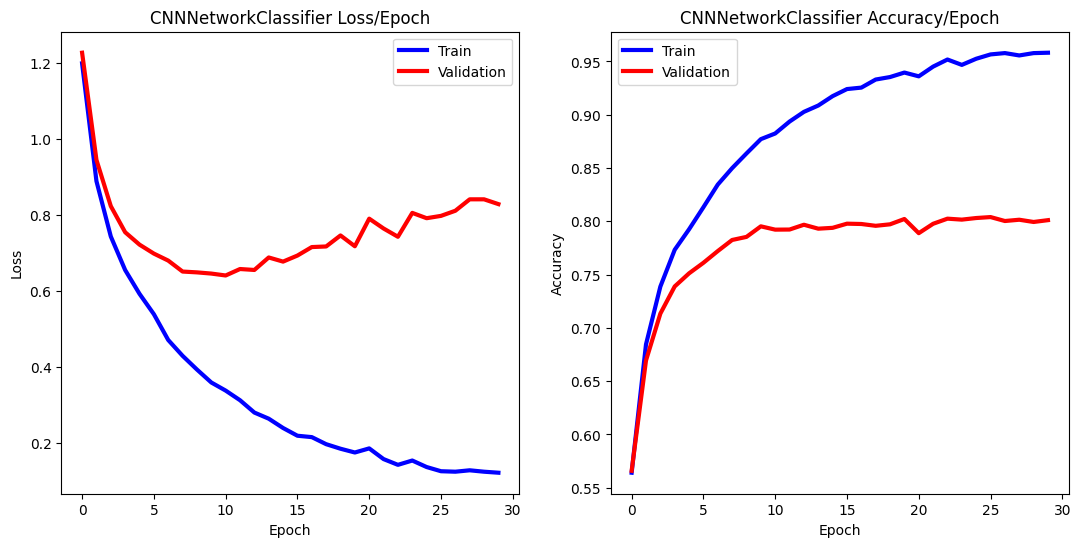

In [48]:
plot_eval("CNNNetworkClassifier",train_acc,test_acc,train_loss,test_loss)

In [49]:
class block(nn.Module):
    def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
        super(block,self).__init__()
        self.expantion = 4
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=1,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,out_channels*self.expantion,kernel_size=1,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expantion)
        self.relu = nn.ReLU()
        self.identitiy_downsample = identity_downsample
    
    def forward(self,x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identitiy_downsample is not None:
            identity = self.identitiy_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x


In [50]:
class ResNet(nn.Module): # [3,4,6,3]
    def __init__(self,block,layers,image_channels,num_classes):
        super(ResNet,self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block,layers[0],out_channels=64,stride=1)
        self.layer2 = self._make_layer(block,layers[1],out_channels=128,stride=2)
        self.layer3 = self._make_layer(block,layers[2],out_channels=256,stride=2)
        self.layer4 = self._make_layer(block,layers[3],out_channels=512,stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)
        return x

        
    
    def _make_layer(self,block,num_residual_blocks,out_channels,stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,
            out_channels*4,
            kernel_size=1,
            stride=stride),
            nn.BatchNorm2d(out_channels*4)
            )
        
        layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
        self.in_channels = out_channels * 4
        
        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels,out_channels))

        return nn.Sequential(*layers)


In [51]:
import datetime


def ResNet50(img_channels=3,num_classes=10):
    return ResNet(block,[3,4,6,3],img_channels,num_classes).to(device)

def train_resnet():
    pass

def train_one_epoch(model,epoch_index, tb_writer):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0001)
    running_loss = 0.
    last_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

def fit(model,timestamp,writer,epoch_number=0,EPOCHS=5,best_vlass=1_000_000.):
    loss_fn = nn.CrossEntropyLoss()
    train_loss , test_loss = np.zeros(EPOCHS) , np.zeros(EPOCHS)
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model,epoch_number, writer)
        train_loss[epoch] = avg_loss

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.cuda()
            vlabels = vlabels.cuda()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        test_loss[epoch] = avg_vloss
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

